# Tarea 2 Machine Learning
## Magíster Ciencia de Datos, UAI
### Profesor Simón Leiva


#### Trabajo de Alejandra Neely

1. Lea los datos de bank_churn.csv y aplique los siguientes tratamientos básicos:


- Remueva las columnas RowNumber, CustomerId, Surname. Ayuda: En Python puede usar df.drop(columnas, axis = 1), donde df es el data frame y columnas es una lista con los nombres de las columnas
- Aplique una partición de train y test de tal forma de dejar 70 % de train y 30 % de test (aplique random_state = 123)
- Genere variables dummies
- Balancee la muestra de train usando oversampling. (aplique random_state = 123)
- Cree las matrices X e y para la muestra de entrenamiento y para la muestra de test

In [31]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import tree
import matplotlib.pyplot as plt
# Selección de conjunto de train y test
from sklearn.model_selection import train_test_split
# Modulo metrics
from sklearn import metrics
# Tree es para los arboles
# preprocessing para imputaciones previas y separaciones de train y test
# matplotlib.pyplot para los gráficos

In [32]:
# Función de lectura de datos
df = pd.read_csv("bank_churn.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [33]:
# remover las columnas RowNumber, CustomerID, Surname

bank = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)
bank = pd.get_dummies(bank)
bank.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [34]:
random_state = 123

# armamos muestra de entrenamiento y testeo
split = train_test_split(bank.index, test_size = 0.3, random_state = 123)

train = bank.loc[split[0]]

test = bank.loc[split[1]]

In [35]:
# Generamos variables dummy para el train
train = pd.get_dummies(train)
x_train = train.drop('Exited', axis = 1)
y_train = train[['Exited']]

x_test = test.drop('Exited', axis = 1)
y_test = test[['Exited']]

In [36]:
# se deduce de aquí que hay un desbalance favorable a los ceros, es decir hacia los no fugados
y_train['Exited'].astype('category').value_counts()

0    5568
1    1432
Name: Exited, dtype: int64

In [37]:
# Realizamos oversampling
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 123) 

x_train, y_train = sm.fit_resample(x_train, y_train) 

In [38]:
# verificamos que se balancearon los datos de acuerdo a la variable dependiente
y_train['Exited'].astype('category').value_counts()

1    5568
0    5568
Name: Exited, dtype: int64

2. Usando la muestra de train que creo en la pregunta 1, ajuste un árbol de decisión con las siguientes características:


- Hasta un máximo de 4 generaciones de hijos
- Ninguna hoja debe tener menos de 50 observaciones
- Ningún nodo con menos de 200 observaciones se debe separar
- Debe usar entropía como criterio
- random_state = 123
- Grafique dicho árbol y obtenga su matriz de confusión. Comente los resultados indicando ajuste en base a la matriz de confusión y las variables más relevantes en función del árbol.

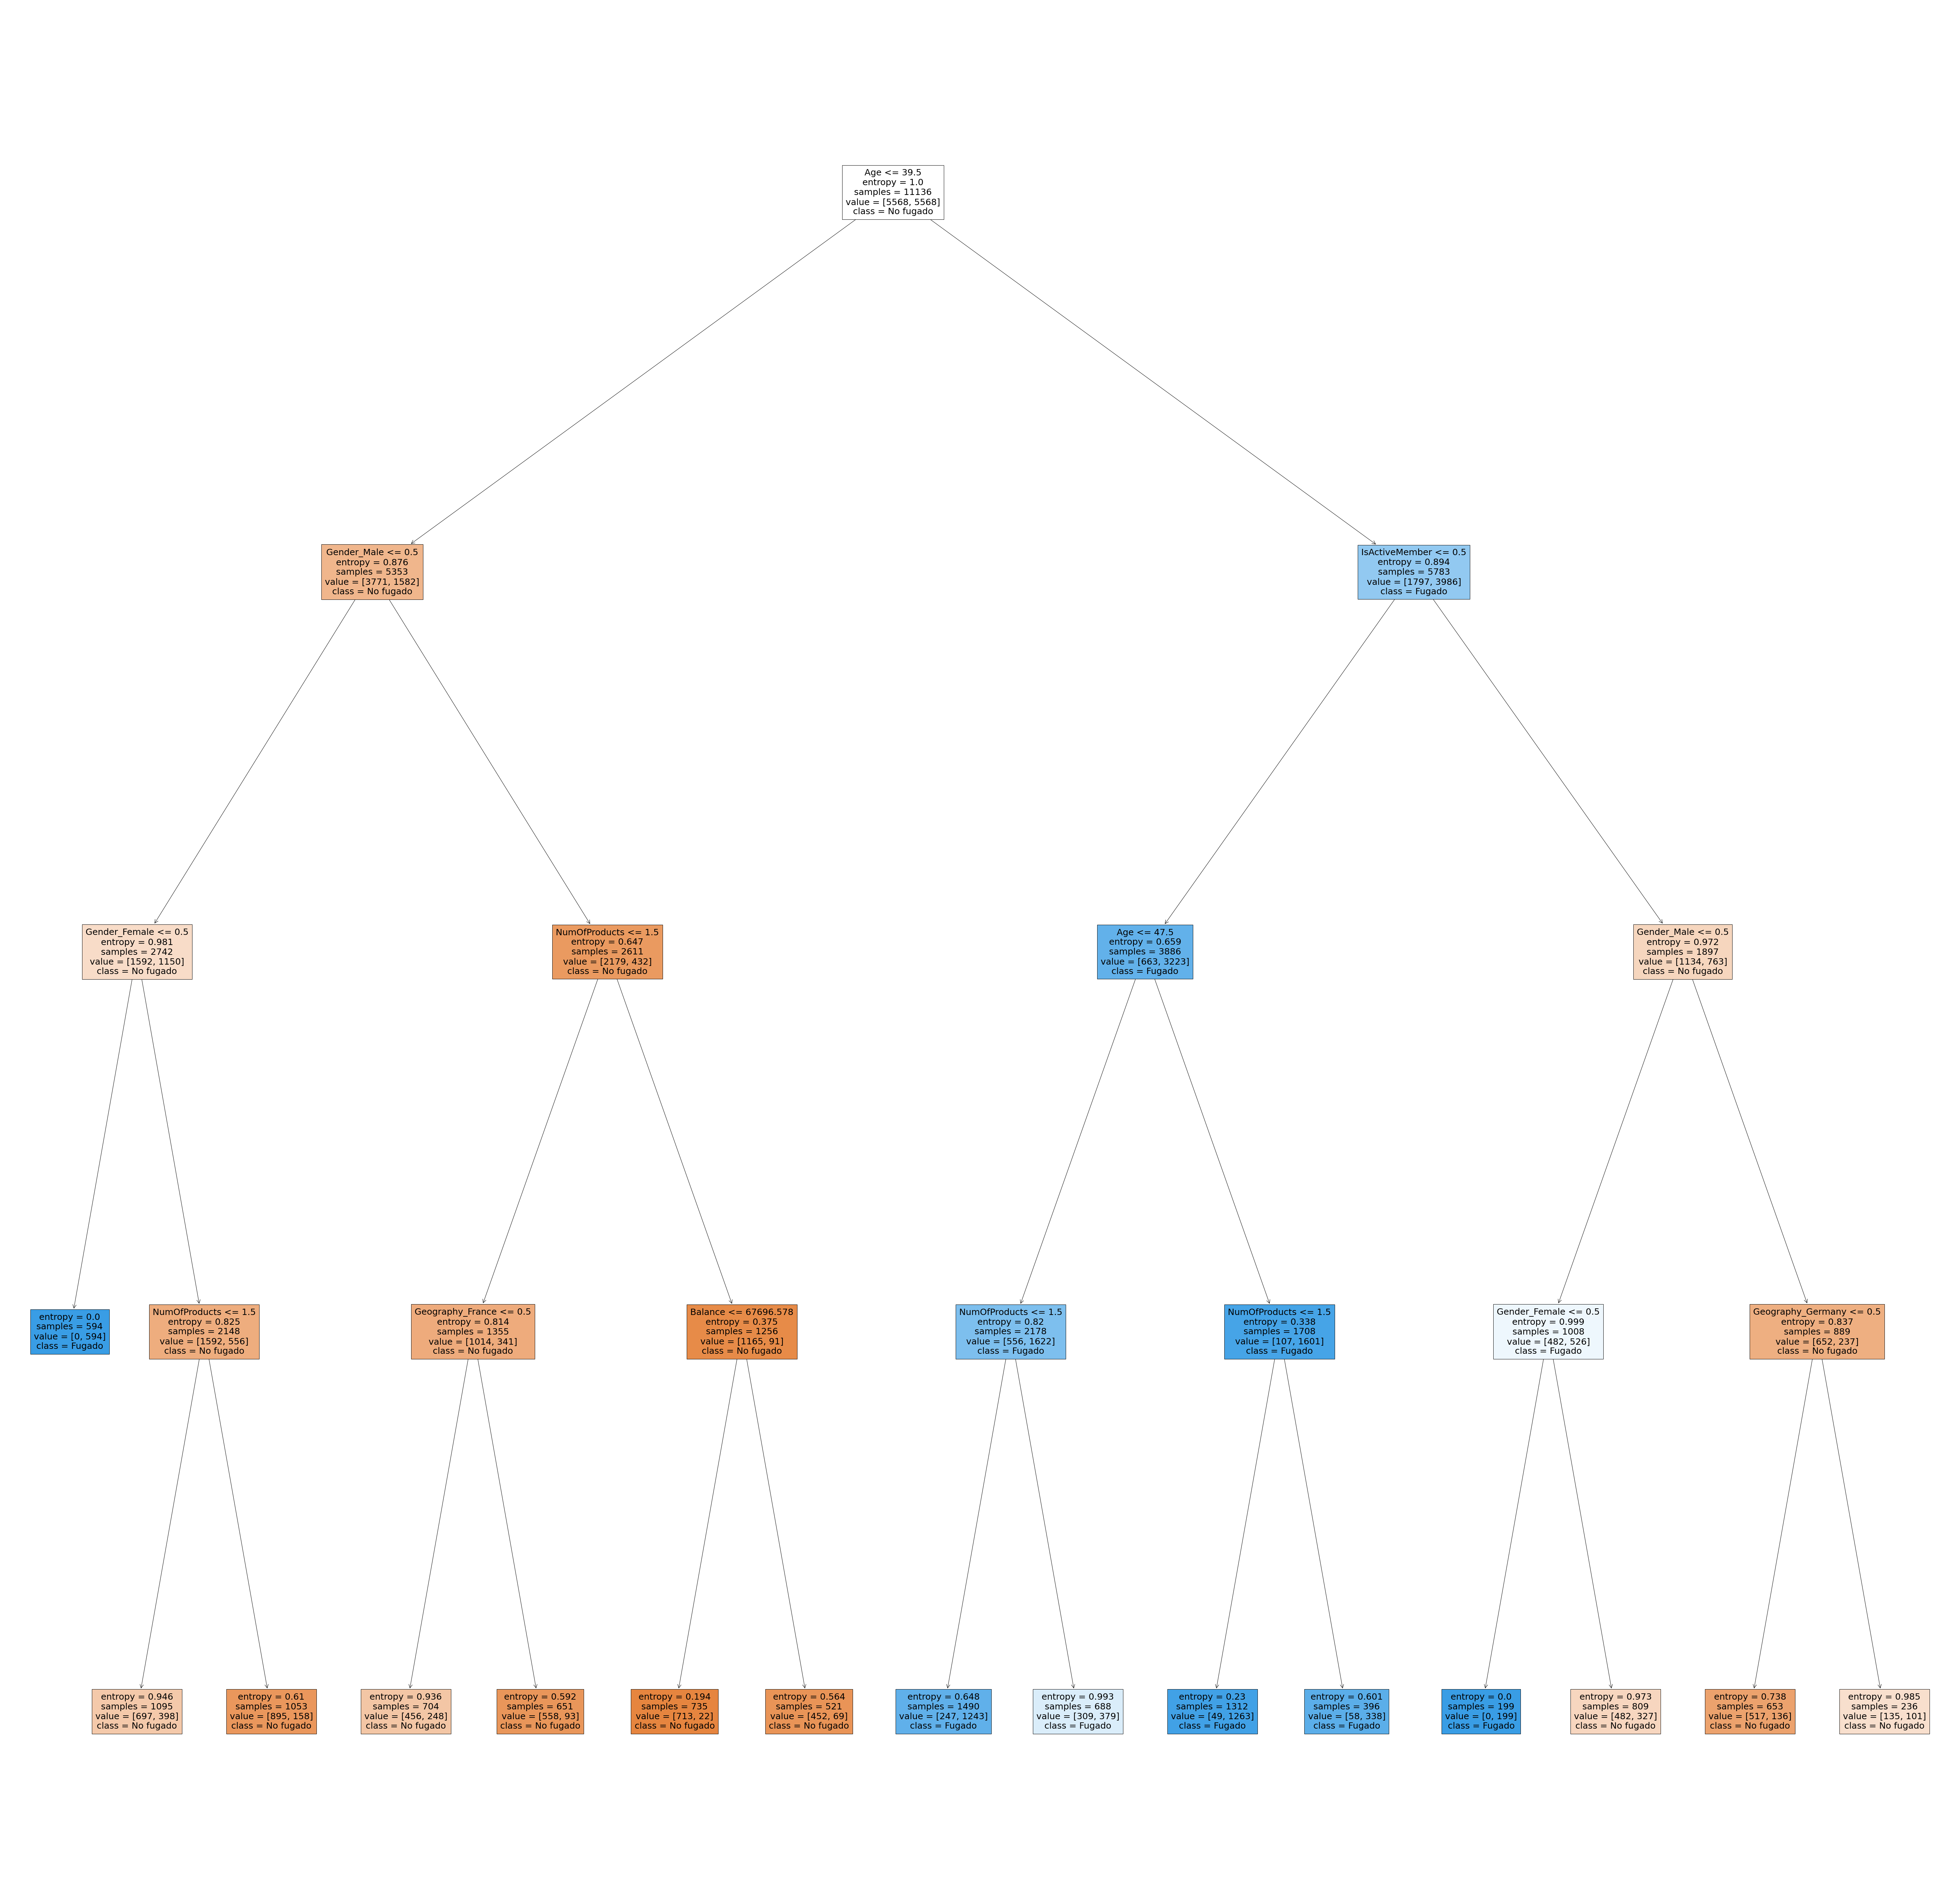

In [39]:
# Árbol de decisión entropía, 4 generaciones de hijos, num min de hojas 50, ningún nodo debe separarse si tiene menos de 200 observaciones
clf = tree.DecisionTreeClassifier(criterion = 'entropy',
                                  max_depth = 4,
                                  min_samples_leaf = 50,
                                  min_samples_split = 200,
                                 random_state = 123)
clf = clf.fit(x_train, y_train)

fig = plt.figure(figsize=(100, 100))
tree.plot_tree(clf, 
               feature_names = x_train.columns,
              class_names = ['No fugado', 'Fugado'],
              filled = True)
fig.savefig("decision_tree.png")

La variable que generó una menor entropía para la clasificación de no fugados (0.194), fue "Balance" (menor a 67.696) asociado a "NumOfProducts"(mayor a 1.5) a su vez asociado a "Gender_Male" (igual a 1, es decir que es hombre), a su vez asociado a "Edad" (menor a 39.5 años). Luego, respecto de la variable que generó una menor entropía para la clasificación de fugados, hay dos ramas que finalizan con entropía dde 0.0. La primera, es la rama de menores de 39.5 años, que no son hombres y tampoco mujeres. La segunda, es la rama de mayores de 39.5 años que son miembros activos y que tampoco son hombre ni mujer. Fácil es sospechar que hay algo mal con esta clasificación, y es que al armar las variables dummy antes de hacer el oversampling, se generaron observaciones con valor "0" para la variable "Gender_Femmale" y también para la variable "Gender_Male", lo cual no ocurre en los datos originales.
Entonces pasaremos al siguiente candidato, con una entropía de 0.23, número de productos menor a 1.5 asociado a una edad mayor a 47.5 años que no es miembro activo y además es mayor de 39.5 años. Así, vemos que la edad, el número de productos y la participación como miembro activo son relevantes para clasificar a los fugados. Mientras que el balance, el número de productos, la edad y el género son variables importantes para predecir a los no fugados.

In [40]:
# Predicciones, predice etiquetas, no probabilidades
preds = clf.predict(x_test)

In [41]:
# Definir que ver en la evaluación
def cl_report(y_test, preds):
    # Matriz de confusión
    print(metrics.confusion_matrix(y_test, preds))
    # Reporte anterior
    print(metrics.classification_report(y_test, preds))
    # Accuracy
    return metrics.accuracy_score(y_test, preds)

In [42]:
cl_report(y_test, preds)

[[2106  289]
 [ 316  289]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2395
           1       0.50      0.48      0.49       605

    accuracy                           0.80      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.80      0.80      0.80      3000



0.7983333333333333

De la matriz de confusión se deduce que el árbol detecta la misma cantidad de verdaderos positivos que de falsos negativos (clasificados como no fugados cuando sí los son) lo cual es necesario tomar en consideración. Luego, si bien la clasificación de no fugados anda mejor, también hay presencia de clasificaciones erradas esta vez con presencia de falsos positivos. Lo anterior se refleja en una precisión mayor y un recall mayor para la categoría 0 que para la categoría 1. 

También, el f1-score es de .87 para la clasificación de no fugados, pero de .49 para la clasificación de fugados, a pesar de que el accuracy de .8 es elevado. Así, podemos ver que a pesar de que el accuracy indica que el modelo funciona bien, en realidad la clasificación falla de forma importante, sobre todo en la detección de fugados.

3. El mismo árbol anterior aplique un ensamblaje usando


- Bagging
- AdaBoost
- Use la misma configuración del árbol y aplique ambos algoritmos generando 100 árboles, usando random_state = 123. Usando validación cruzada (5 Folds) indique cual mostró mejores resultados en cuanto a accuracy. Ajuste los modelos a la muestra de test y obtenga las matrices de confusión. Compare y concluya

## Bagging

In [43]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state = 123)

In [44]:
from sklearn.ensemble import BaggingClassifier
arboles = BaggingClassifier(base_estimator = clf, # Modelo base
                            n_estimators = 100, # Cantidad de muestras bootstrap a realizar
                           n_jobs = 2,
                           random_state = 123) # Ejecución en paralelo, indica la cantidad de núcleos en que se repartirán los procesos en paralelo

In [45]:
arboles = arboles.fit(x_train, y_train)
preds = arboles.predict(x_test)

/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [46]:
cv = cross_validate(arboles, # Modelo
                    X = x_train, # Features
                    y = y_train, # Label
                    cv = kf, # "Folds" o particiones en la validación cruzada
                   scoring = metrics.make_scorer(cl_report)) # retornar validaciones para muestra entrenamiento

/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[1009  120]
 [ 273  826]]
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1129
           1       0.87      0.75      0.81      1099

    accuracy                           0.82      2228
   macro avg       0.83      0.82      0.82      2228
weighted avg       0.83      0.82      0.82      2228



/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[1005  113]
 [ 311  798]]
              precision    recall  f1-score   support

           0       0.76      0.90      0.83      1118
           1       0.88      0.72      0.79      1109

    accuracy                           0.81      2227
   macro avg       0.82      0.81      0.81      2227
weighted avg       0.82      0.81      0.81      2227



/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[989 115]
 [260 863]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1104
           1       0.88      0.77      0.82      1123

    accuracy                           0.83      2227
   macro avg       0.84      0.83      0.83      2227
weighted avg       0.84      0.83      0.83      2227



/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[981 131]
 [276 839]]
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1112
           1       0.86      0.75      0.80      1115

    accuracy                           0.82      2227
   macro avg       0.82      0.82      0.82      2227
weighted avg       0.82      0.82      0.82      2227



/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[961 144]
 [249 873]]
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1105
           1       0.86      0.78      0.82      1122

    accuracy                           0.82      2227
   macro avg       0.83      0.82      0.82      2227
weighted avg       0.83      0.82      0.82      2227



## AdaBoost

In [47]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(base_estimator = clf, # indicar el modelo base a aplicar adaBoost
                                n_estimators = 100,
                             random_state = 123) # Cantidad de iteraciones totales, es cuantos modelos se ensamblarán

In [48]:
adaboost = adaboost.fit(x_train, y_train)
preds = adaboost.predict(x_test)

/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [49]:
cv_adaboost = cross_validate(adaboost,
                             X = x_train, # Features
                             y = y_train, # Label
                             cv = kf, # "Folds" o particiones en la validación cruzada
                             scoring = metrics.make_scorer(cl_report)) 


/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[998 131]
 [196 903]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1129
           1       0.87      0.82      0.85      1099

    accuracy                           0.85      2228
   macro avg       0.85      0.85      0.85      2228
weighted avg       0.85      0.85      0.85      2228



/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[990 128]
 [169 940]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1118
           1       0.88      0.85      0.86      1109

    accuracy                           0.87      2227
   macro avg       0.87      0.87      0.87      2227
weighted avg       0.87      0.87      0.87      2227



/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[977 127]
 [142 981]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1104
           1       0.89      0.87      0.88      1123

    accuracy                           0.88      2227
   macro avg       0.88      0.88      0.88      2227
weighted avg       0.88      0.88      0.88      2227



/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[990 122]
 [158 957]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1112
           1       0.89      0.86      0.87      1115

    accuracy                           0.87      2227
   macro avg       0.87      0.87      0.87      2227
weighted avg       0.87      0.87      0.87      2227



/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[952 153]
 [152 970]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1105
           1       0.86      0.86      0.86      1122

    accuracy                           0.86      2227
   macro avg       0.86      0.86      0.86      2227
weighted avg       0.86      0.86      0.86      2227



Luego de haber ajustado tanto Bagging como Adaboost, vemos que ambos generan una mejora importante respecto del árbol de decisión ajustado inicialmente, y que a su vez, Adaboost tiene un desempeño mejor que Bagging. Primero que todo respecto del accuracy, el modelo con Adaboost fue el que presentó niveles más alto. Sin embargo, el accuracy solo nos entrega parte de la información, también es importante ver si hay una cantidad baja de falsos positivos y falsos negativos y si además no hay un desbalance en la capacidad de detectar observaciones de cada categoría. Para chequear esto último, nos fijamos en la precisión, recall y el f-1 score, y observamos que efectivamente hay una menor diferencia entre estos valores tanto en Bagging, pero sobre todo en Adaboost. Y también estos indicadores adoptan valores bastante estables entre submuestras y elevados en ambos casos, aunque sobre todo en el modelo ajustado con Adaboost. Al hacer validación cruzada es que vemos la estabilidad del modelo en diferentes submuestras, presentando poca variación cuando se seleccionan diferentes submuestras de los datos de entrenamiento para ajustarlo.

4. A los datos anteriores aplique un ligthGBM. Los parámetros deben ser encontrados de acuerdo a la siguiente grilla:


- Profundidad máxima [6, 7, 8, 9]
- Número de iteraciones [80, 100, 120, 140]
- Tasa de aprendizaje [0.3, 0.4, 0.5, 0.6]
- random_state = 123
- Obtenga el mejor resultado, luego ajuste ese modelo con todos los datos de train. Prediga con ese modelo las probabilidades de fuga del conjunto de test y obtenga el área bajo la curva de ROC (AUC)

## Light GBM

In [50]:
# importar RF
from lightgbm import LGBMClassifier

In [51]:
lgbm_c = LGBMClassifier(n_jobs = 2, # Número de jobs en paralelo
                        reg_alpha = 0.0, # Regularización L1
                        reg_lambda = 0.0, # Regularización L2
                        num_leaves = 500,
                        random_state = 123,
                        silent = True) # Evitar mucho output


In [52]:
# Importamos busqueda de grilla
from sklearn.model_selection import GridSearchCV

# La grilla se define como diccionario, con el nombre de los parámetros como llaves del diccionario
# los valores son los valores en los cuales ir iterando
grilla = {'max_depth': [6,7,8,9],
         'n_estimators': [80,100,120,140],
         'learning_rate': [0.3,0.4,0.5,0.6]}

gsearch = GridSearchCV(lgbm_c,  # modelo a evaluar
                       param_grid = grilla, # Indicar diccionario de grilla
                       cv = kf, # particiones de validación cruzada
                       n_jobs = 2) # cantidad de nucleos para paralelizar el proceso
gsearch.fit(x_train, y_train)

/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=LGBMClassifier(n_jobs=2, num_leaves=500,
                                      random_state=123),
             n_jobs=2,
             param_grid={'learning_rate': [0.3, 0.4, 0.5, 0.6],
                         'max_depth': [6, 7, 8, 9],
                         'n_estimators': [80, 100, 120, 140]})

In [53]:
resultados = pd.DataFrame(gsearch.cv_results_).sort_values(['rank_test_score'])

In [54]:
resultados.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.629926,0.050117,0.041212,0.003291,0.3,9,140,"{'learning_rate': 0.3, 'max_depth': 9, 'n_esti...",0.889587,0.898967,0.899865,0.896722,0.886394,0.894307,0.005354,1
63,0.549496,0.019104,0.037327,0.002493,0.6,9,140,"{'learning_rate': 0.6, 'max_depth': 9, 'n_esti...",0.885996,0.895375,0.907948,0.893579,0.884598,0.893499,0.008340,2
46,0.581643,0.033328,0.037164,0.002344,0.5,9,120,"{'learning_rate': 0.5, 'max_depth': 9, 'n_esti...",0.884201,0.894926,0.897171,0.895375,0.893579,0.893050,0.004571,3
59,0.435174,0.008794,0.035328,0.000578,0.6,8,140,"{'learning_rate': 0.6, 'max_depth': 8, 'n_esti...",0.881059,0.890436,0.901661,0.894477,0.896722,0.892871,0.006930,4
13,0.449090,0.013240,0.029307,0.000939,0.3,9,100,"{'learning_rate': 0.3, 'max_depth': 9, 'n_esti...",0.885548,0.898967,0.900763,0.890436,0.888639,0.892871,0.005949,5
14,0.566344,0.035959,0.038969,0.002335,0.3,9,120,"{'learning_rate': 0.3, 'max_depth': 9, 'n_esti...",0.885996,0.897620,0.899416,0.894028,0.886843,0.892781,0.005482,6
29,0.436663,0.019302,0.028024,0.000253,0.4,9,100,"{'learning_rate': 0.4, 'max_depth': 9, 'n_esti...",0.887792,0.893130,0.898518,0.899416,0.884598,0.892691,0.005812,7
44,0.361812,0.014710,0.025340,0.002035,0.5,9,80,"{'learning_rate': 0.5, 'max_depth': 9, 'n_esti...",0.880610,0.895375,0.899865,0.898069,0.889088,0.892602,0.007021,8
57,0.307891,0.010346,0.025699,0.001553,0.6,8,100,"{'learning_rate': 0.6, 'max_depth': 8, 'n_esti...",0.890485,0.887741,0.900314,0.892681,0.891783,0.892601,0.004202,9
30,0.512072,0.032014,0.034335,0.000936,0.4,9,120,"{'learning_rate': 0.4, 'max_depth': 9, 'n_esti...",0.890934,0.894028,0.899865,0.896273,0.881904,0.892601,0.006091,10


In [55]:
resultados.iloc[0,7]

{'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 140}

In [56]:
lgbm_cbest = LGBMClassifier(learning_rate = 0.3, # Tasa de aprendizaje
                        max_depth = 9, # Podado del árbol
                        n_estimators = 140, # Número de iteraciones
                        n_jobs = 2, # Número de jobs en paralelo
                        reg_alpha = 0.0, # Regularización L1
                        reg_lambda = 0.0, # Regularización L2
                        num_leaves = 500,
                        random_state = 123,
                        silent = True) # Evitar mucho output

In [57]:
lgbm_cbest = lgbm_cbest.fit(x_train, y_train)
preds_A = lgbm_cbest.predict(x_test)
probs_A_churn = lgbm_cbest.predict_proba(x_test)[:, 1]
probs_A_churn_tr = lgbm_cbest.predict_proba(x_train)[:, 1]

/home/ale/env3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


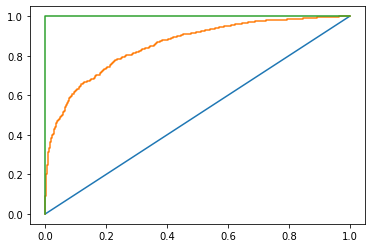

In [58]:
roc = metrics.roc_curve(y_test, probs_A_churn)
roc_tr = metrics.roc_curve(y_train, probs_A_churn_tr)
plt.plot([0,1], [0,1])
plt.plot(roc[0], roc[1])
plt.plot(roc_tr[0], roc_tr[1])

In [59]:
metrics.roc_auc_score(y_test, probs_A_churn)

0.8554909504994911

In [60]:
metrics.roc_auc_score(y_train, probs_A_churn_tr)

1.0

El valor AUC (que identifica la proporción de la tasa de verdaderos positivos y la tasa de falsos positivos) indica un buen ajuste del modelo. Sin embargo, ya que el AUC de la muestra de entrenamiento es igual a 1.0, es muy probable que el modelo esté sobre ajustado, es decir que sea poco estable y cuando entren nuevos datos no logre predecir la variable dependiente al nivel esperado. 

Así, y a modo de conclusión, si bien los métodos de ensamblaje por Boosting mostraron un mejor desempeño, también es conocido que estos métodos tienden a sobreajustarse más rápido y fácilmente, por lo que es posible que la mejor decisión dado este conjunto de datos y los modelos probados, sea tomar el modelo del árbol de decisión utilizando el método de ensamblaje por Bagging, ya que tuvo un desempeño considerablemente mejor que el árbol de decisión sin ensamblaje, y puede que presente mejor estabilidad que usando el método de ensamblaje por Boosting.